# Station selection

In this notebook, 30 geographically distributed weather stations in Austria are selected for further use in a machine learning process.

Data is requested from GeoSphere Austria via an API to fetch station-specific details.

Clustering method K-Means is used to identify suitable geographical distributions of the stations to make a comrehensive representation for modeling.

Station locations are visualized on the map to ensure their correct distribution.

The **distributed_stations.csv** file with the selected stations data is saved and will be used in the next steps.

In [3]:
!pip install geopandas matplotlib shapely folium

     -------------------------------------- 110.5/110.5 kB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 85.1/85.1 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from shapely.geometry import Polygon
import geopandas as gpd

## Load the data

### Stations metadata

In [5]:
metadata_url = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1d/metadata"

response = requests.get(metadata_url)
if response.status_code == 200:
    stations = response.json()['stations']
    print("Sucessfully fetched metadata!")
else:
    print(f"Failed to fetch metadata. Status code: {response.status_code}")

Sucessfully fetched metadata!


In [6]:
stations_df = pd.DataFrame(stations)

print(stations_df.head())

       type  id  group_id              name             state       lat  \
0  COMBINED   1       NaN            Aflenz        Steiermark  47.54594   
1  COMBINED   2       NaN  Aigen im Ennstal        Steiermark  47.53278   
2  COMBINED   3       NaN       Allentsteig  Niederösterreich  48.69083   
3  COMBINED   4       NaN         Amstetten  Niederösterreich  48.10889   
4  COMBINED   5       NaN        Bad Aussee        Steiermark  47.61050   

        lon  altitude                 valid_from                   valid_to  \
0  15.24069     783.2  1983-05-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   
1  14.13826     641.0  1939-03-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   
2  15.36694     598.8  1983-10-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   
3  14.89500     266.0  1936-01-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   
4  13.75844     743.1  1983-09-01T00:00:00+00:00  2100-12-31T00:00:00+00:00   

   has_sunshine  has_global_radiation  is_active  
0          True        

In [7]:
# Parse 'valid_from' and 'valid_to'
stations_df['valid_from'] = pd.to_datetime(stations_df['valid_from'])
stations_df['valid_to'] = pd.to_datetime(stations_df['valid_to'])

# Define the required valid range
required_start = pd.to_datetime('2016-01-01T00:00:00+00:00')
required_end = pd.to_datetime('2023-12-31T00:00:00+00:00')

# Filter stations valid for the entire range (inclusive of borders)
filtered_stations = stations_df[
    (stations_df['valid_from'] <= required_start) &
    (stations_df['valid_to'] >= required_end)
]

print(f"Stations valid from {required_start.date()} to {required_end.date()}: {len(filtered_stations)}")
print(filtered_stations)

# Perform K-Means clustering on filtered stations
if len(filtered_stations) >= 30:  # Ensure there are enough stations for clustering
    coordinates = filtered_stations[['lat', 'lon']]

    # Perform K-Means clustering
    num_clusters = 30
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    filtered_stations['Cluster'] = kmeans.fit_predict(coordinates)

    # Select one station from each cluster
    distributed_stations = filtered_stations.groupby('Cluster').first().reset_index()

    # Save to CSV for the further use
    distributed_stations.to_csv("data/distributed_stations.csv", index=False)

    print("Distributed Stations:")
    print(distributed_stations)
else:
    print("Not enough valid stations for clustering. Please adjust the time range or number of clusters.")

Stations valid from 2016-01-01 to 2023-12-31: 462
            type     id  group_id                      name             state  \
0       COMBINED      1       NaN                    Aflenz        Steiermark   
1       COMBINED      2       NaN          Aigen im Ennstal        Steiermark   
2       COMBINED      3       NaN               Allentsteig  Niederösterreich   
3       COMBINED      4       NaN                 Amstetten  Niederösterreich   
4       COMBINED      5       NaN                Bad Aussee        Steiermark   
...          ...    ...       ...                       ...               ...   
1064  INDIVIDUAL  20270       NaN               Feldkirchen           Kärnten   
1076  INDIVIDUAL  20411     188.0  Völkermarkt Goldbrunnhof           Kärnten   
1077  INDIVIDUAL  20412      91.0     Feistritz ob Bleiburg           Kärnten   
1086  INDIVIDUAL  21101     206.0              Loibl Tunnel           Kärnten   
1087  INDIVIDUAL  21300      21.0           Bad Eisenkappel

C:\Users\Мария\AppData\Local\Temp\ipykernel_42504\3221327479.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_stations['Cluster'] = kmeans.fit_predict(coordinates)


#### Visualizing the stations on the map

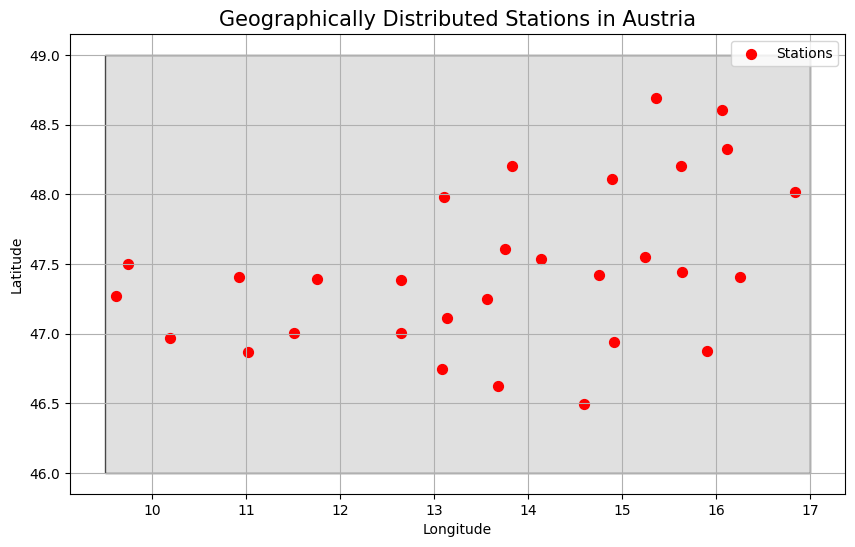

In [8]:
# Create Austria's boundary (approximation)
austria = gpd.GeoDataFrame({
    'country': ['Austria'],
    'geometry': [Polygon([(9.5, 46.0), (17.0, 46.0), (17.0, 49.0), (9.5, 49.0), (9.5, 46.0)])]
}, crs="EPSG:4326")


selected_stations = distributed_stations
stations_gdf = gpd.GeoDataFrame(
    selected_stations,
    geometry=gpd.points_from_xy(selected_stations['lon'], selected_stations['lat']),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))
austria.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.7)
stations_gdf.plot(ax=ax, color="red", markersize=50, label="Stations")

plt.title("Geographically Distributed Stations in Austria", fontsize=15)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [9]:
# Create a map centered on Austria
austria_map = folium.Map(location=[47.5, 14.5], zoom_start=7)

# Add station markers to the map
for _, row in selected_stations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"Station: {row['name']}<br>Lat: {row['lat']}<br>Lon: {row['lon']}",  # Popup with station info
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(austria_map)

# Save the map to an HTML file and display it
austria_map.save("data/austrian_stations_map.html")
austria_map